# Air quality model

Ping Chen

# Abstract #
This data set comes from UCI, which contains the responses of gas multi-sensor devices deployed on site in Italian cities. In addition to temperature, it also records hourly averaged concentration CO, hourly averaged NOx concentration in ppb, AH Absolute Humidity and so on. My goal is to predict the temperature. I will clean the data first, and then analyze the data to find out which factors have a greater impact on the temperature. Then I will use H2O to build a model to predict the temperature.

# ① What is the question? #
I used a data set for predictive learning to predict temperature through a series of information (hourly averaged concentration CO, hourly averaged NOx concentration in ppb, AH Absolute Humidity and so on).

# ② What did you do? #

Data Cleaning and Progressing：

We will process the data, including removing illegal data (missing value), Then preprocessing for the model, Cause we use a new copy of the dataset, so we still need to convert all the categorical types to numeric. Finally The data will be divided into 75% for training and 25% for testing.

Feature Selection and Data Analysis:

After the data is processed, it is necessary to analyze the data, such as analyzing which factors have the greatest influence. This can improve the efficiency of subsequent model building. We will choose HeatMap, Variable importance graph, etc. to calculate which independent variables are important variables.

Fit models and Find the best model:

We will first fit the linear model, then use AutoML to build other models, and then use the function of H2O to find the best model.

Interpretability:

Interpretability is the last part of machine learning.We chose to use SHAP to explain our top 3 previous models.


# ③ How well did it work? #
We used the linear model and the models built by H2O AutoML (gbm, glm, etc.), how to judge the pros and cons of each model, we can call Hyper-Parameter Search Summary to get the mse of each model, the smaller the mse, the model The smaller the prediction error, the table shows that gbm18 is the model with the smallest mse.


For Interpretability we used SHAP analysis to calculate the marginal contribution of independent variables. Shapley is also the only model interpretation method that satisfies efficiency symmetry and additivity. It can calculate all the features, and can also compare among them. Through the SHAP value distribution of each feature, and the predicted SHAP value value, conclusions can be drawn.


# ④ What did you learn? #
From the p-value in the linear regression analysis, we can know that AH and RH are the most significant variable.and the other variable’s importance.

we can tell from the z_value. In GLM model ,except NO2(GT), PT08.S3(NOx),PT08.S1(CO) are less than abs( 1.96) .Other variable is significant to the response.

We can get the mse of each model from the Hyper-Parameter Search Summary table. The smaller the mse, the smaller the model prediction error. The table shows that gbm18 is the model with the smallest mse. gbm18 is the prediction model with the smallest error

From the results of our SHAP analysis of the three models, we can conclusion:
AH is very important to the model, and most of AH blue points have a shap value of less than 0, which has a negative impact;
The bigger the eigenvalue, the shap is greater than 0, which has a positive impact
From a horizontal perspective, the AH feature, the sample distribution is relatively scattered, which means that the feature has a greater impact.
In addition, such as feature NO2(GT), most of the points are diffused in SHAP = 0, so it has little effect on temperature.


# 1. Import Library and Data

In [1]:
!apt-get install default-jre 
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
openjdk version "11.0.17" 2022-10-18
OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)


In [2]:
! pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177.5 MB 40 kB/s 
  Created wheel for h2o: filename=h2o-3.38.0.3-py2.py3-none-any.whl size=177541401 sha256=05affb50c05c3d02332fe001fe368dfdfca977076db81c9587a933c7068e971b
  Stored in directory: /root/.cache/pip/wheels/16/f8/f4/69e1ff6a0d1cb61bdbc0d9888ee8437a1acf1eb1c6ffb8be20
Successfully built h2o


In [3]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [ ]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp7p5kghg_
  JVM stdout: /tmp/tmp7p5kghg_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp7p5kghg_/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_unknownUser_qty5ad
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


import the data set

In [5]:
url = "https://raw.githubusercontent.com/ChenPingA/Air-Quality-Data-Set/main/AirQualityUCI.csv"
df = h2o.import_file(path = url)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# 2. Data Cleaning

In [6]:
# return an output of the dataframe
df.head()

Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,C16,C17
2004-03-10 00:00:00,1970-01-01 18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,nan,nan
2004-03-10 00:00:00,1970-01-01 19:00:00,2,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,nan,nan
2004-03-10 00:00:00,1970-01-01 20:00:00,2.2,1402,88,9,939,131,1140,114,1555,1074,11.9,54,0.7502,nan,nan
2004-03-10 00:00:00,1970-01-01 21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11,60,0.7867,nan,nan
2004-03-10 00:00:00,1970-01-01 22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,nan,nan
2004-03-10 00:00:00,1970-01-01 23:00:00,1.2,1197,38,4.7,750,89,1337,96,1393,949,11.2,59.2,0.7848,nan,nan
2004-03-11 00:00:00,1970-01-01 00:00:00,1.2,1185,31,3.6,690,62,1462,77,1333,733,11.3,56.8,0.7603,nan,nan
2004-03-11 00:00:00,1970-01-01 01:00:00,1,1136,31,3.3,672,62,1453,76,1333,730,10.7,60,0.7702,nan,nan
2004-03-11 00:00:00,1970-01-01 02:00:00,0.9,1094,24,2.3,609,45,1579,60,1276,620,10.7,59.7,0.7648,nan,nan
2004-03-11 00:00:00,1970-01-01 03:00:00,0.6,1010,19,1.7,561,-200,1705,-200,1235,501,10.3,60.2,0.7517,nan,nan


In [8]:
# return an output type of the dataframe
df.types

{'Date': 'time',
 'Time': 'time',
 'CO(GT)': 'real',
 'PT08.S1(CO)': 'int',
 'NMHC(GT)': 'int',
 'C6H6(GT)': 'real',
 'PT08.S2(NMHC)': 'int',
 'NOx(GT)': 'int',
 'PT08.S3(NOx)': 'int',
 'NO2(GT)': 'int',
 'PT08.S4(NO2)': 'int',
 'PT08.S5(O3)': 'int',
 'T': 'real',
 'RH': 'real',
 'AH': 'real',
 'C16': 'int',
 'C17': 'int'}

In [9]:
df.describe()

Rows:9471
Cols:17

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,C16,C17
type,time,time,real,int,int,real,int,int,int,int,int,int,real,real,real,int,int
mins,1078876800000.0,0.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,NaN,NaN
mean,1095741005193.9729,41394806.027572945,-34.20752377898901,1048.990060916961,-159.09009297851875,1.8656834455487874,894.5952762637594,168.61697125146938,794.990167788821,58.148872501870244,1391.4796409105481,975.0720316340708,9.77830501229027,39.48537992946456,-6.837603644330444,0.0,0.0
maxs,1112572800000.0,82800000.0,11.9,2040.0,1189.0,63.7,2214.0,1479.0,2683.0,340.0,2775.0,2523.0,44.6,88.7,2.231,NaN,NaN
sigma,9724648294.22172,24923453.80027478,77.65717034683163,329.8327098861881,139.78909289678148,41.38020643630012,342.3332516496718,257.4338662910737,321.99355160311603,126.9404552589075,467.21012455706364,456.93818447398843,43.203623062623194,51.21614497176605,38.97667016632423,-0.0,-0.0
zeros,0,390,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
missing,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114,9471,9471
0,2004-03-10 00:00:00,1970-01-01 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,nan,nan
1,2004-03-10 00:00:00,1970-01-01 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,nan,nan
2,2004-03-10 00:00:00,1970-01-01 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,nan,nan


remove the missing value

In [10]:
#some values are marked as -200 so we need to remove them
mask = df['CO(GT)'] > -200
s1 = df[mask,:]
s1.describe

<bound method H2OFrame.describe of H2OFrame({'_ex': <Expr(rows <Expr()#AirQualityUCI_20T.hex> <Expr(> <Expr(cols_py <Expr()#AirQualityUCI_20T.hex> 'CO(GT)'); scalar> -200); scalar>); scalar>})>

In [ ]:
# the final removed code and now the dataset become s12
mask = s1['AH'] > -200
s12 = s1[mask,:]
s12.describe

In [22]:
s12.describe()

Rows:6941
Cols:17

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,C16,C17
type,time,time,real,int,int,real,int,int,int,int,int,int,real,real,real,int,int
mins,1078876800000.0,0.0,0.1,647.0,-200.0,0.2,390.0,2.0,322.0,2.0,551.0,221.0,-1.9,9.2,0.1847,NaN,NaN
mean,1096292667454.2573,43272612.01555972,2.182466503385679,1119.9132689814148,-148.64457570955193,10.554487825961674,958.543005330644,250.6719492868464,816.8933871200115,113.87408154444604,1452.6488978533353,1057.7565192335398,17.75532344042645,48.881904624693846,0.9855727416798732,0.0,0.0
maxs,1112572800000.0,82800000.0,11.9,2040.0,1189.0,63.7,2214.0,1479.0,2683.0,333.0,2775.0,2523.0,44.6,88.7,2.1806,NaN,NaN
sigma,10209950756.50728,24530127.460908916,1.4411578844974917,218.73375371137746,157.07675309957494,7.4652263285217915,264.05500158779716,208.61137082789276,251.89719985517954,47.47501685972731,353.30157566388084,406.5099568661767,8.844908952625895,17.433193302036663,0.4010966206986037,-0.0,-0.0
zeros,0,308,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6941,6941
0,2004-03-10 00:00:00,1970-01-01 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,nan,nan
1,2004-03-10 00:00:00,1970-01-01 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,nan,nan
2,2004-03-10 00:00:00,1970-01-01 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,nan,nan


In [23]:
s12.shape

(6941, 17)

In [24]:
# Create a 75/25 train/test splie
pct_rows=0.75
s12_train, s12_test = s12.split_frame([pct_rows])

In [25]:
print(s12_train.shape)
print(s12_test.shape)

(5213, 17)
(1728, 17)


# 3.Fit a linear model and Find best model


In [26]:
# return an output of the dataframe
s12_train.head()

Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,C16,C17
2004-03-10 00:00:00,1970-01-01 18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,nan,nan
2004-03-10 00:00:00,1970-01-01 19:00:00,2,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,nan,nan
2004-03-10 00:00:00,1970-01-01 20:00:00,2.2,1402,88,9,939,131,1140,114,1555,1074,11.9,54,0.7502,nan,nan
2004-03-10 00:00:00,1970-01-01 23:00:00,1.2,1197,38,4.7,750,89,1337,96,1393,949,11.2,59.2,0.7848,nan,nan
2004-03-11 00:00:00,1970-01-01 00:00:00,1.2,1185,31,3.6,690,62,1462,77,1333,733,11.3,56.8,0.7603,nan,nan
2004-03-11 00:00:00,1970-01-01 01:00:00,1,1136,31,3.3,672,62,1453,76,1333,730,10.7,60,0.7702,nan,nan
2004-03-11 00:00:00,1970-01-01 02:00:00,0.9,1094,24,2.3,609,45,1579,60,1276,620,10.7,59.7,0.7648,nan,nan
2004-03-11 00:00:00,1970-01-01 05:00:00,0.7,1066,8,1.1,512,16,1918,28,1182,422,11,56.2,0.7366,nan,nan
2004-03-11 00:00:00,1970-01-01 06:00:00,0.7,1052,16,1.6,553,34,1738,48,1221,472,10.5,58.1,0.7353,nan,nan
2004-03-11 00:00:00,1970-01-01 07:00:00,1.1,1144,29,3.2,667,98,1490,82,1339,730,10.2,59.6,0.7417,nan,nan


In [27]:
s12_train.describe()

Rows:5213
Cols:17

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,C16,C17
type,time,time,real,int,int,real,int,int,int,int,int,int,real,real,real,int,int
mins,1078876800000.0,0.0,0.1,649.0,-200.0,0.2,397.0,2.0,325.0,5.0,561.0,225.0,-1.9,9.2,0.1862,NaN,NaN
mean,1096240863073.0865,43374026.47228082,2.1855361596009972,1120.387492806446,-148.0778822175331,10.562593516209475,959.221369652791,250.40821024362177,816.3719547285634,113.8628428927681,1454.7239593324389,1056.6667945520812,17.793439478227505,48.86245923652406,0.9878547861116441,0.0,0.0
maxs,1112572800000.0,82800000.0,11.9,2040.0,1189.0,63.7,2214.0,1479.0,2559.0,333.0,2775.0,2523.0,44.6,88.7,2.1806,NaN,NaN
sigma,10215408648.53616,24499948.32635217,1.440140309477233,218.197849371974,157.84212094932943,7.463604782022019,262.99839742668814,208.17233185125409,250.38200123521673,47.16307361476047,352.95156566963846,404.9084744041654,8.825802188632018,17.417099131240683,0.4020376466302126,-0.0,-0.0
zeros,0,229,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5213,5213
0,2004-03-10 00:00:00,1970-01-01 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,nan,nan
1,2004-03-10 00:00:00,1970-01-01 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,nan,nan
2,2004-03-10 00:00:00,1970-01-01 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,nan,nan


show what features are remained

In [28]:
# Set the features and target
X=s12.columns
print(X)

['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'C16', 'C17']


In [29]:
# Set target and predictor variables
y='T'
X.remove(y) 
X.remove('Date')
X.remove("Time")
X.remove('C16')
X.remove('C17')
X.remove('NMHC(GT)')

print(X)


['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'RH', 'AH']


 Set a minimum memory size and a run time in seconds

In [30]:
min_mem_size=6 
run_time=222

In [31]:
# Use 50% of availible resources
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

6


In [32]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

Set machine learning parameters

In [33]:
gbm_params1 = {'learn_rate': [0.01, 0.1],
                'max_depth': [3, 5, 9],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.2, 0.5, 1.0]}

Show Hyper-Parameter Search Summary

In [34]:
gbm_grid1 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)
gbm_grid1.train(x=X, y=y,
                training_frame=s12_train,
                validation_frame=s12_test,
                ntrees=100,
                seed=1)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate,learn_rate,max_depth,sample_rate,model_ids,residual_deviance
,1.0,0.1,9.0,0.8,gbm_grid1_model_18,0.0587499
,1.0,0.1,9.0,1.0,gbm_grid1_model_36,0.0792075
,1.0,0.1,5.0,0.8,gbm_grid1_model_12,0.1022848
,1.0,0.1,5.0,1.0,gbm_grid1_model_30,0.1139435
,1.0,0.1,3.0,1.0,gbm_grid1_model_24,0.2724597
,1.0,0.1,3.0,0.8,gbm_grid1_model_6,0.2931110
,0.5,0.1,9.0,1.0,gbm_grid1_model_35,0.3130614
,0.5,0.1,9.0,0.8,gbm_grid1_model_17,0.3303522
,0.5,0.1,5.0,1.0,gbm_grid1_model_29,0.3857319
,0.5,0.1,5.0,0.8,gbm_grid1_model_11,0.4078398


In [35]:
gbm_gridperf1 = gbm_grid1.get_grid( sort_by='mse',decreasing=False)


In [36]:
gbm_gridperf1


,col_sample_rate,learn_rate,max_depth,sample_rate,model_ids,mse
,1.0,0.1,9.0,0.8,gbm_grid1_model_18,0.0587499
,1.0,0.1,9.0,1.0,gbm_grid1_model_36,0.0792075
,1.0,0.1,5.0,0.8,gbm_grid1_model_12,0.1022848
,1.0,0.1,5.0,1.0,gbm_grid1_model_30,0.1139435
,1.0,0.1,3.0,1.0,gbm_grid1_model_24,0.2724597
,1.0,0.1,3.0,0.8,gbm_grid1_model_6,0.2931110
,0.5,0.1,9.0,1.0,gbm_grid1_model_35,0.3130614
,0.5,0.1,9.0,0.8,gbm_grid1_model_17,0.3303522
,0.5,0.1,5.0,1.0,gbm_grid1_model_29,0.3857319
,0.5,0.1,5.0,0.8,gbm_grid1_model_11,0.4078398


In [37]:
best_gbm1 = gbm_gridperf1.models[0]

In [38]:
best_gbm_perf1 = best_gbm1.model_performance(s12_test)
best_gbm_perf1.mse


<bound method MetricsBase.mse of H2ORegressionModelMetrics({'_metric_json': {'__meta': {'schema_version': 3, 'schema_name': 'ModelMetricsRegressionV3', 'schema_type': 'ModelMetricsRegression'}, 'model': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'gbm_grid1_model_18', 'type': 'Key<Model>', 'URL': '/3/Models/gbm_grid1_model_18'}, 'model_checksum': -3268935382677568000, 'frame': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'py_28_sid_b3a8', 'type': 'Key<Frame>', 'URL': '/3/Frames/py_28_sid_b3a8'}, 'frame_checksum': 3099875170727837372, 'description': None, 'model_category': 'Regression', 'scoring_time': 1670806890735, 'predictions': None, 'MSE': 0.05874987203865511, 'RMSE': 0.2423837289065731, 'nobs': 1728, 'custom_metric_name': None, 'custom_metric_value': 0.0, 'r2': 0.9992585192313163, 'mean_residual_deviance': 0.05874987203865511, 'mae': 0.14761441639368195, 'rmsle': 'NaN'}, 

In [39]:
air_glm = H2OGeneralizedLinearEstimator( lambda_ = 0,
                        remove_collinear_columns = True,
                          compute_p_values = True)

In [40]:
air_glm.train(x = X, y = y, training_frame = s12_train, validation_frame = s12_test)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1670806804516_1


GLM Model: summary
    family    link      regularization    number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ----------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  None              11                            11                             1                       py_27_sid_b3a8

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 5.452964423828219
RMSE: 2.335158329498927
MAE: 1.7483171630482026
RMSLE: NaN
Mean Residual Deviance: 5.452964423828219
R^2: 0.9299823381933877
Null degrees of freedom: 5212
Residual degrees of freedom: 5201
Null deviance: 405987.6152381358
Residual deviance: 28426.30354141651
AIC: 23661.93205652007

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 5.374041857929607
RMSE: 2.3181979764311778
MAE: 1.7205580190155985
RMSLE: NaN
Mean Residual Deviance: 5.374041857929607
R^2: 0.9321743426924488
Null degrees of freedom: 1727
Residual degrees of freedom: 1716
Null deviance: 136955.42400141043
Residual deviance: 9286.344330502361
AIC: 7835.622327658665

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective          training_rmse      training_deviance    training_mae        training_r2         validation_rmse     validation_deviance    validation_mae      validation_r2
--  -------------------  ----------  ------------  -------------------------  -----------------  -----------------  -------------------  ------------------  ------------------  ------------------  ---------------------  ------------------  ------------------
    2022-12-12 01:01:31  0.000 sec   0             405987.61563015525         77.87984186268085
    2022-12-12 01:01:31  0.202 sec   1                                                           2.335158329498927  5.452964423828219    1.7483171630482026  0.9299823381933877  2.3181979764311778  5.374041857929607      1.7205580190155985  0.9321743426924488

Variable Importances: 
variable       relative_importance    scaled_importance    percentage
-------------  ---------------------  -------------------  ------------
RH             5.91923                1                    0.264481
AH             5.69048                0.961354             0.25426
C6H6(GT)       2.75216                0.464953             0.122971
PT08.S2(NMHC)  2.50145                0.422597             0.111769
PT08.S4(NO2)   2.28864                0.386644             0.10226
PT08.S5(O3)    1.01968                0.172265             0.0455609
CO(GT)         0.878737               0.148455             0.0392635
NOx(GT)        0.861289               0.145507             0.0384839
PT08.S1(CO)    0.268833               0.045417             0.0120119
PT08.S3(NOx)   0.198939               0.0336089            0.00888893
NO2(GT)        0.00108476             0.000183261          4.84691e-05

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [41]:
air_glm = H2OGeneralizedLinearEstimator(   lambda_= 1,
                        remove_collinear_columns = True,
                          )
air_glm.train(x = X, y = y, training_frame = s12_train, validation_frame = s12_test)

glm Model Build progress: |

/usr/local/lib/python3.8/dist-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: remove_collinear_columns should only be used with no regularization, i.e. lambda=0.0.  It is used improperly here.  Please set lambda=0.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1670806804516_2


GLM Model: summary
    family    link      regularization                            number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ----------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 1.0 )  11                            7                              1                       py_27_sid_b3a8

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 5.664458197580438
RMSE: 2.380012226351041
MAE: 1.7744232639862096
RMSLE: NaN
Mean Residual Deviance: 5.664458197580438
R^2: 0.9272666961363667
Null degrees of freedom: 5212
Residual degrees of freedom: 5205
Null deviance: 405987.6152381358
Residual deviance: 29528.820583986824
AIC: 23852.296391278258

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 5.604622546277009
RMSE: 2.367408402932838
MAE: 1.7424550172120505
RMSLE: NaN
Mean Residual Deviance: 5.604622546277009
R^2: 0.9292641891873149
Null degrees of freedom: 1727
Residual degrees of freedom: 1720
Null deviance: 136955.42400141043
Residual deviance: 9684.787759966672
AIC: 7900.21804897569

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective          training_rmse      training_deviance    training_mae        training_r2         validation_rmse    validation_deviance    validation_mae      validation_r2
--  -------------------  ----------  ------------  -------------------------  -----------------  -----------------  -------------------  ------------------  ------------------  -----------------  ---------------------  ------------------  ------------------
    2022-12-12 01:01:31  0.000 sec   0             405987.61563015525         77.87984186268085
    2022-12-12 01:01:31  0.038 sec   1                                                           2.380012226351041  5.664458197580438    1.7744232639862096  0.9272666961363667  2.367408402932838  5.604622546277009      1.7424550172120505  0.9292641891873149

Variable Importances: 
variable       relative_importance    scaled_importance    percentage
-------------  ---------------------  -------------------  ------------
RH             6.13913                1                    0.31494
AH             5.71332                0.93064              0.293096
C6H6(GT)       3.01198                0.49062              0.154516
PT08.S4(NO2)   2.31135                0.376496             0.118573
PT08.S2(NMHC)  1.46279                0.238274             0.075042
NOx(GT)        0.594316               0.096808             0.0304887
NO2(GT)        0.260125               0.0423717            0.0133445
CO(GT)         0                      0                    0
PT08.S1(CO)    0                      0                    0
PT08.S3(NOx)   0                      0                    0
PT08.S5(O3)    0                      0                    0

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [42]:
coeff_table = air_glm._model_json['output']['coefficients_table']

In [43]:
coeff_table.as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,10.292072,17.793439
1,CO(GT),0.000000,0.000000
2,PT08.S1(CO),0.000000,0.000000
3,C6H6(GT),-0.403555,-3.011975
4,PT08.S2(NMHC),0.005562,1.462794
5,NOx(GT),0.002855,0.594316
6,PT08.S3(NOx),0.000000,0.000000
7,NO2(GT),-0.005515,-0.260125
8,PT08.S4(NO2),0.006549,2.311353
9,PT08.S5(O3),0.000000,0.000000


In [44]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)

In [45]:
aml.train(x=X,y=y,training_frame=s12_train) 

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,0.2631166,0.0074647,0.2729099,0.2643060,0.2592917,0.2530064,0.2660689
mean_residual_deviance,0.1399651,0.0259360,0.1858071,0.1326161,0.1223663,0.1276205,0.1314155
mse,0.1399651,0.0259360,0.1858071,0.1326161,0.1223663,0.1276205,0.1314155
null_deviance,81230.88,4374.7007,88766.79,79088.01,78350.15,81337.78,78611.69
r2,0.9982072,0.0002722,0.9977375,0.9982014,0.9983773,0.9983588,0.9983612
residual_deviance,146.33508,30.822674,200.48582,142.03181,127.13856,133.36346,128.65578
rmse,0.3729560,0.0329562,0.4310534,0.3641649,0.3498089,0.3572402,0.3625128
rmsle,0.0418893,0.0047013,0.0434270,0.0366117,nan,nan,0.0456291


In [46]:
#Show the leaderboard of all the model
print(aml.leaderboard)

model_id                                                    rmse       mse       mae    rmsle    mean_residual_deviance
StackedEnsemble_AllModels_3_AutoML_1_20221212_10131     0.374641  0.140356  0.263153      nan                  0.140356
StackedEnsemble_BestOfFamily_4_AutoML_1_20221212_10131  0.378413  0.143197  0.26626       nan                  0.143197
XGBoost_grid_1_AutoML_1_20221212_10131_model_3          0.430648  0.185458  0.30487       nan                  0.185458
StackedEnsemble_BestOfFamily_3_AutoML_1_20221212_10131  0.508665  0.25874   0.368726      nan                  0.25874
StackedEnsemble_AllModels_2_AutoML_1_20221212_10131     0.510613  0.260725  0.366649      nan                  0.260725
StackedEnsemble_AllModels_1_AutoML_1_20221212_10131     0.532343  0.283389  0.3824        nan                  0.283389
StackedEnsemble_BestOfFamily_2_AutoML_1_20221212_10131  0.553566  0.306436  0.40089       nan                  0.306436
GBM_grid_1_AutoML_1_20221212_10131_model_

In [47]:
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_s12=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_s12['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break 
  model_index=model_index+1  
for m in aml_leaderboard_s12['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break  
  glm_index=glm_index+1 
    
models_dict

{'StackedEnsemble_AllModels_3_AutoML_1_20221212_10131': 0,
 'StackedEnsemble_BestOfFamily_4_AutoML_1_20221212_10131': 1,
 'XGBoost_grid_1_AutoML_1_20221212_10131_model_3': 2,
 'GLM_1_AutoML_1_20221212_10131': 24}

In [49]:
#Show the best model and save another model as a test model to contrast
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])

2


In [50]:
best_model.algo

'xgboost'

In [51]:
#Show the varible importance in the plot
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

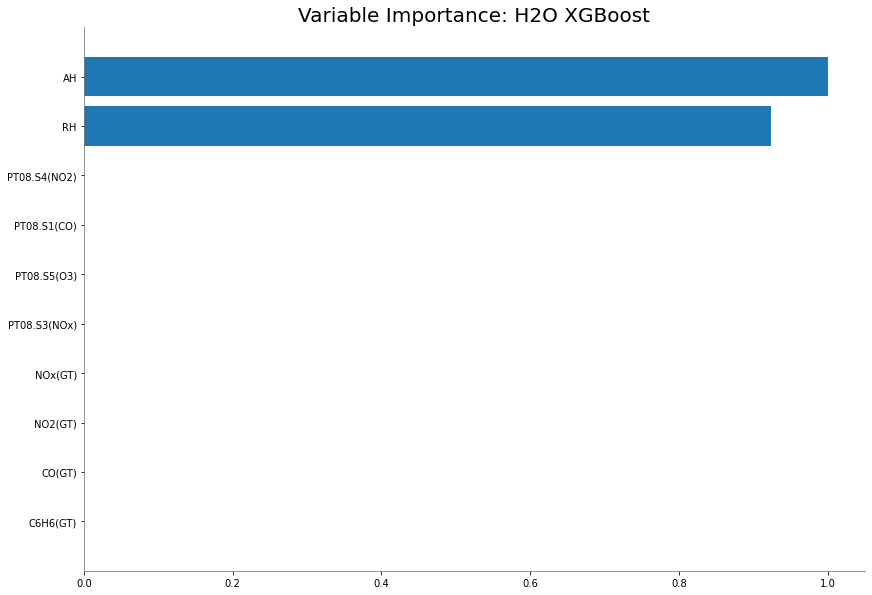

<Figure size 432x288 with 0 Axes>

In [53]:
if best_model.algo in ['gbm','drf','xrt','xgboost']:
  best_model.varimp_plot()

<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-54-dd7790b8306f>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if glm_index is not 0:


24
glm


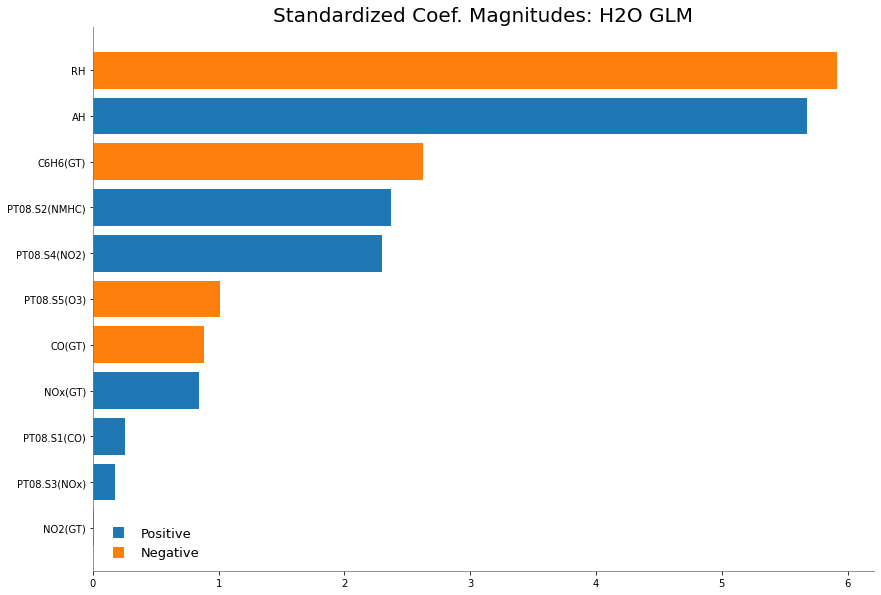

In [54]:
if glm_index is not 0:
  print(glm_index)
  glm_model=h2o.get_model(aml.leaderboard[glm_index,'model_id'])
  print(glm_model.algo) 
  glm_model.std_coef_plot()

In [56]:
#Show the model’s rmse
print(best_model.rmse(train = True))


0.22671162671924774


In [57]:
#Show the model’s rmse and mse using in test set
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d

In [58]:
mod_perf=best_model.model_performance(s12_test)
stats_test={}
stats_test=model_performance_stats(mod_perf)
stats_test

{'mse': 0.18201408058860474,
 'rmse': 0.4266310825392411,
 'null_degrees_of_freedom': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'null_deviance': None}

In [59]:
predictions = best_model.predict(s12_test)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [60]:

#Show the five prediction value 
y_pred=h2o.as_list(predictions)
y_pred[0:5]

,predict
0,11.404912
1,11.548642
2,10.695763
3,9.876626
4,8.483538


In [61]:
print(X)

['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'RH', 'AH']


How RH influence Temperature in the best Model(XGBoost):

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


[PartialDependence: Partial Dependence Plot of model XGBoost_grid_1_AutoML_1_20221212_10131_model_3 on column 'AH'.
ah        mean_response    stddev_response    std_error_mean_response
--------  ---------------  -----------------  -------------------------
0.1847    0.159893         3.80846            0.0457129
0.289747  1.88265          5.15075            0.0618243
0.394795  5.85984          5.68321            0.0682155
0.499842  8.76763          6.41328            0.0769784
0.604889  11.3664          6.41474            0.076996
0.709937  13.8814          6.51172            0.07816
0.814984  16.0022          6.64861            0.0798031
0.920032  18.1181          6.6956             0.0803671
1.02508   19.8535          6.921              0.0830726
1.13013   21.4862          6.76772            0.0812328
1.23517   22.9538          6.99571            0.0839694
1.34022   24.1599          6.91646            0.0830181
1.44527   25.7631          6.78528            0.0814435
1.55032   26.5225

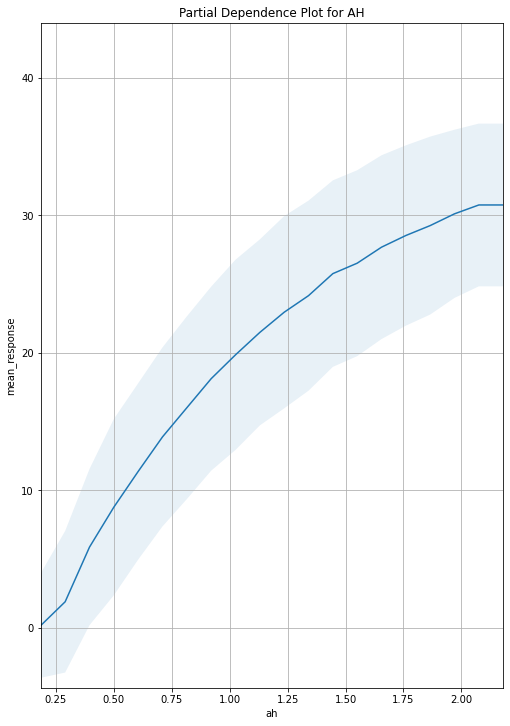

In [62]:

best_model.partial_plot(s12, cols=['AH'])

# 4.Run SHAP analysis on the models above, interpret the SHAP values and compare them with the other model interpretability methods.

**1. SHAP for GLM model**

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

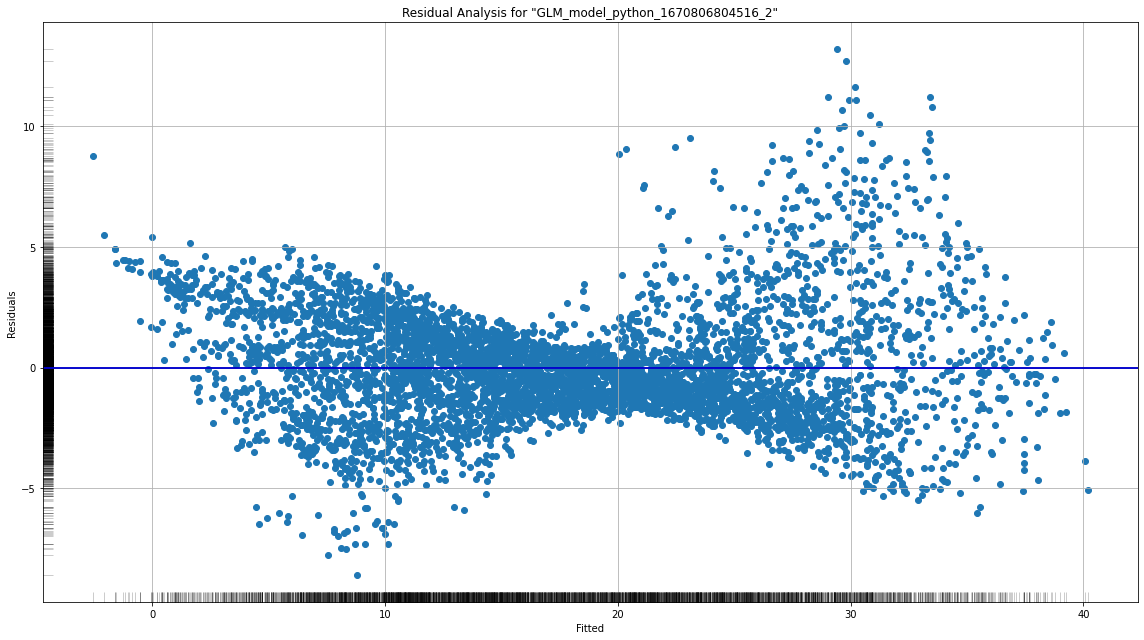

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

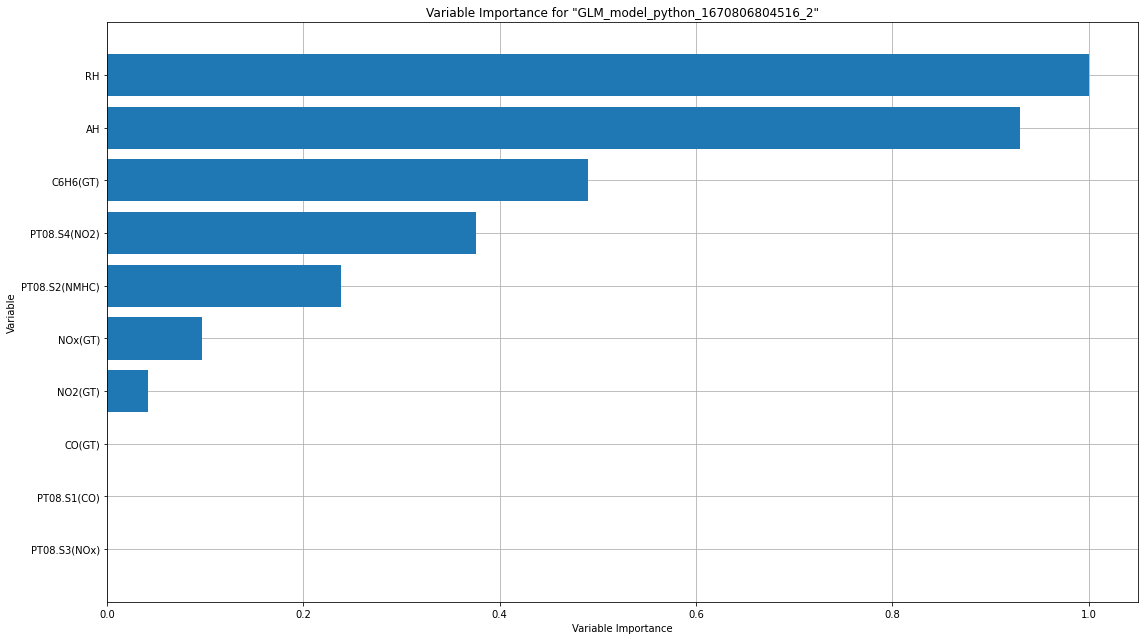

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

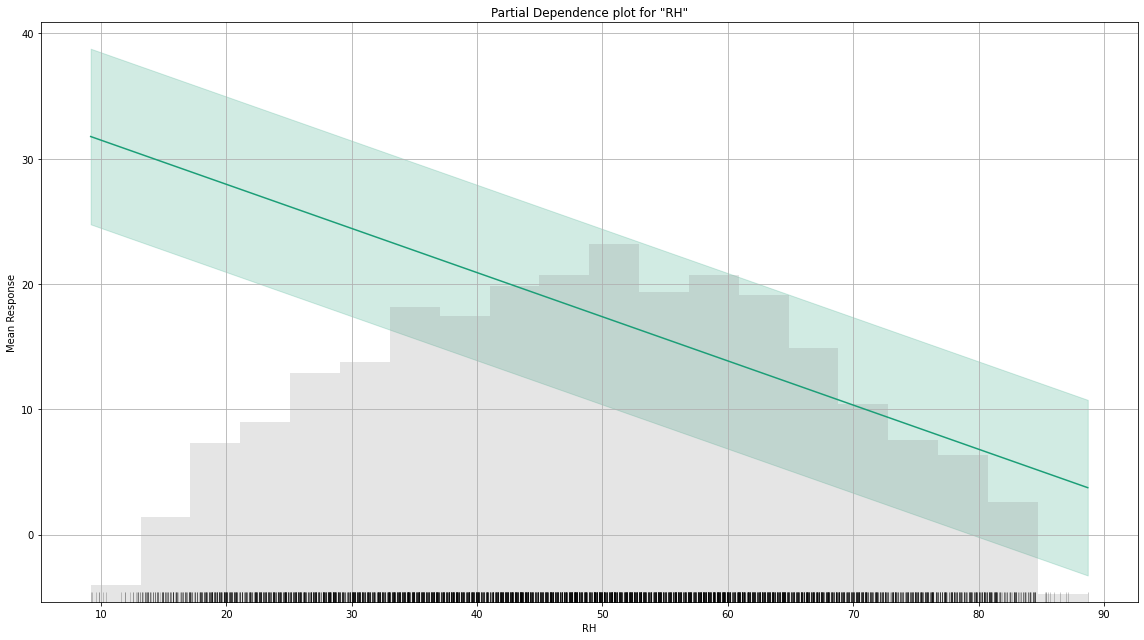

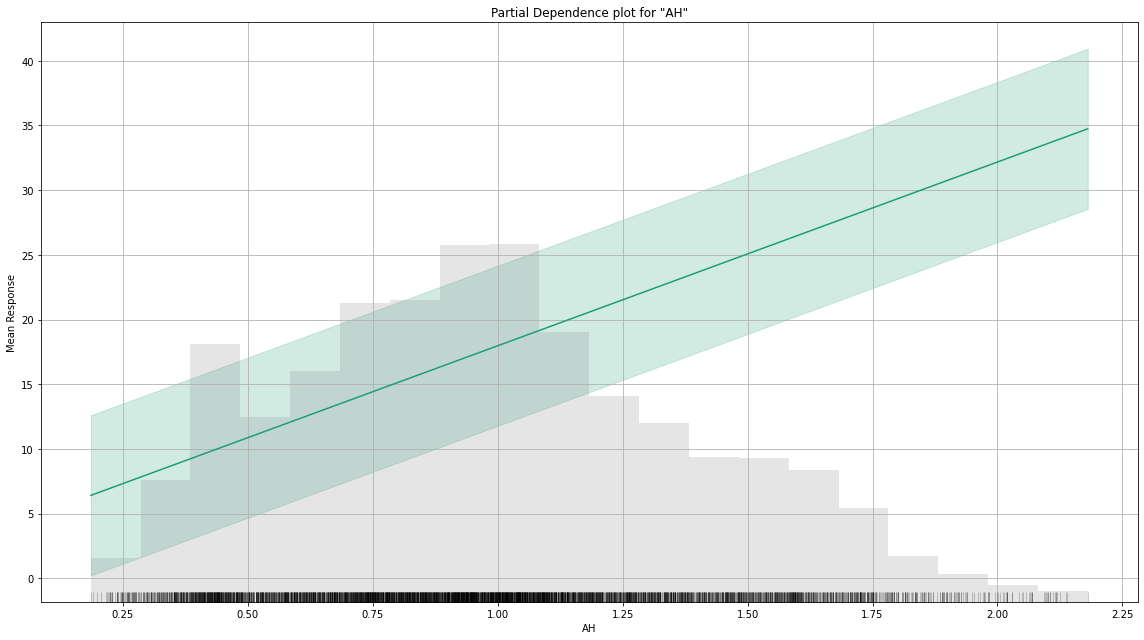

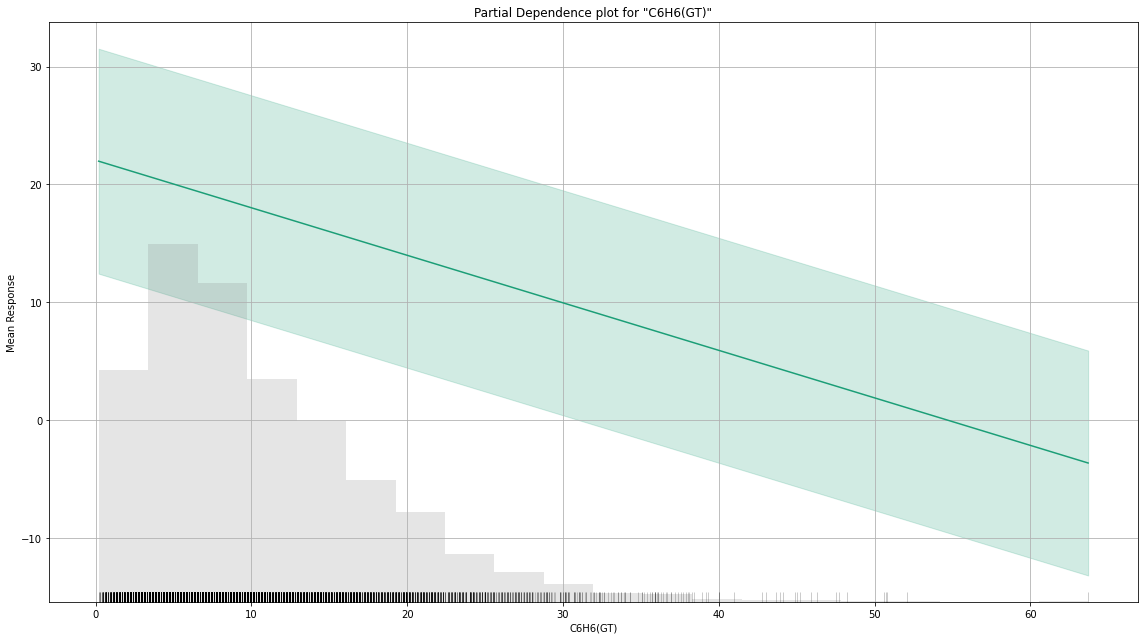

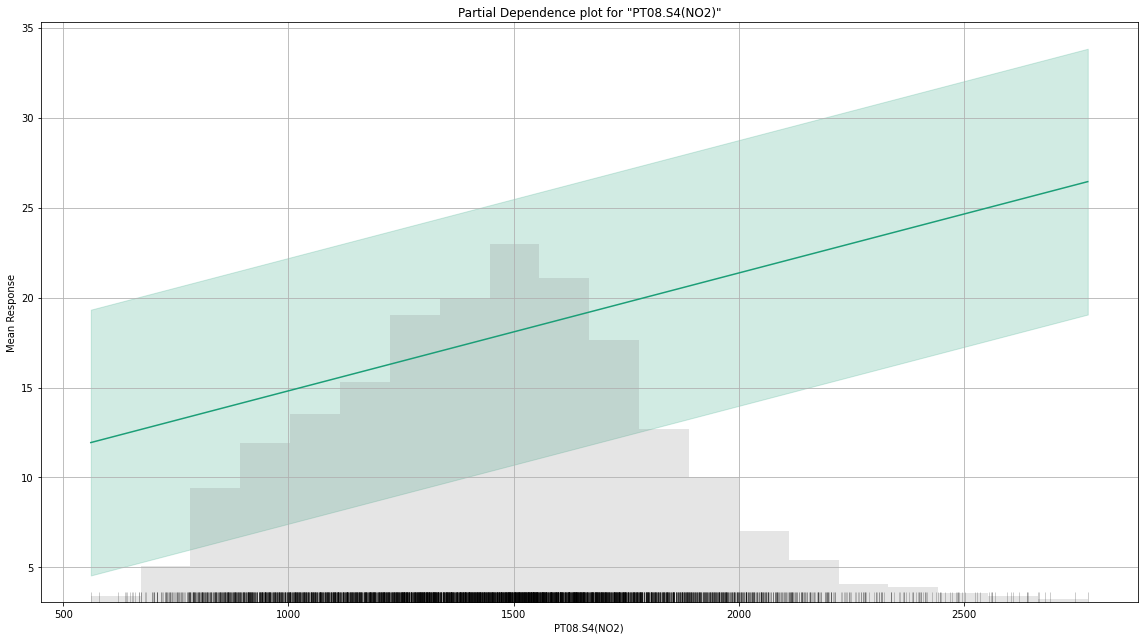

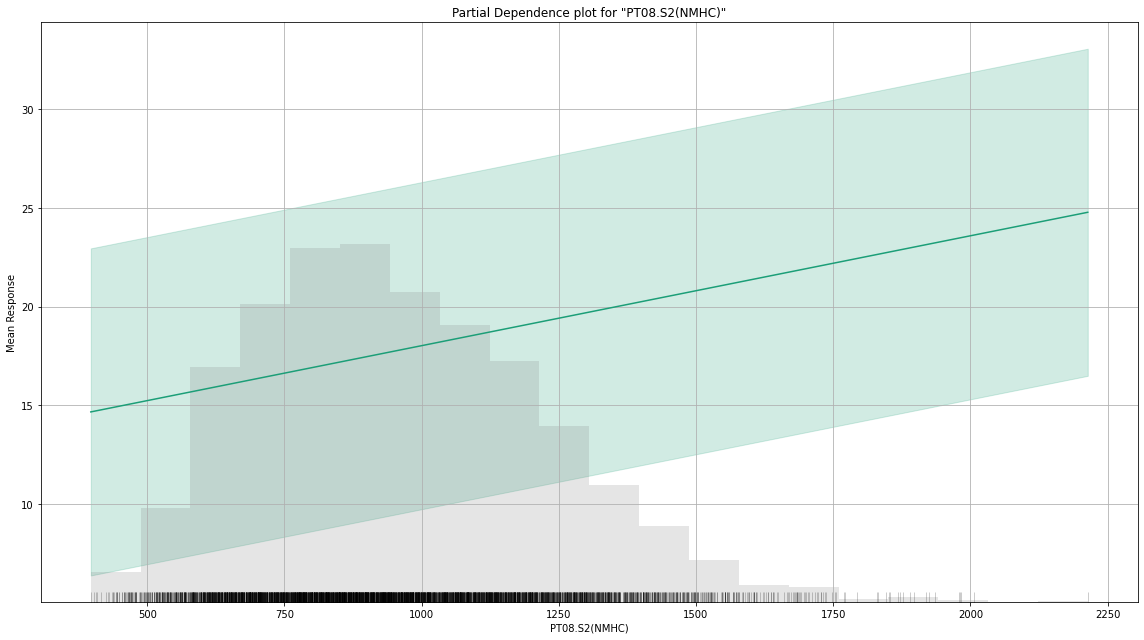

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

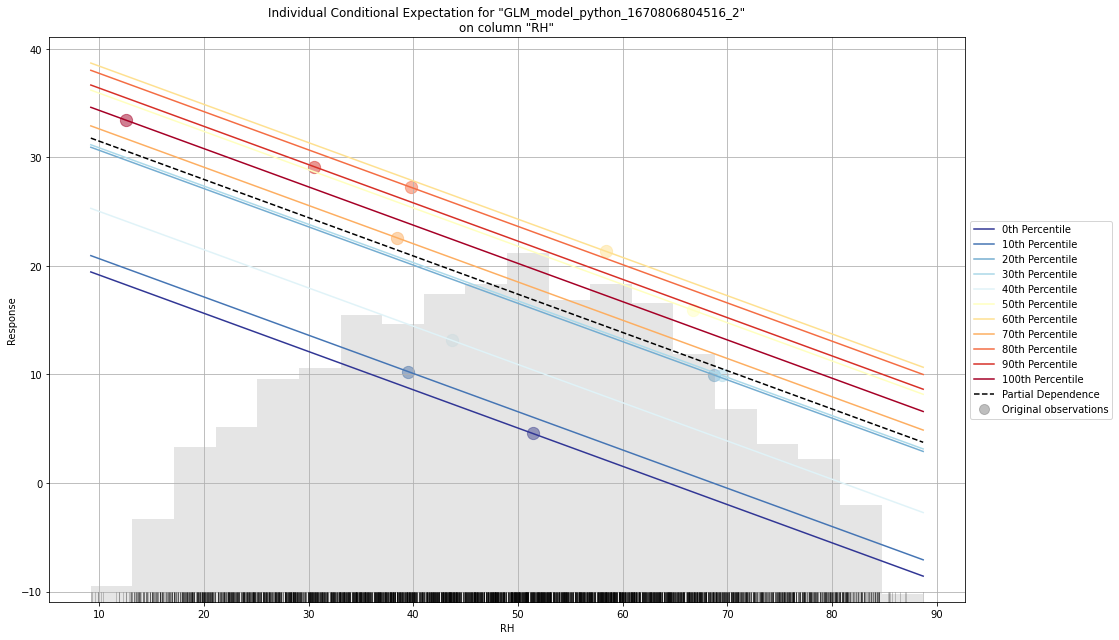

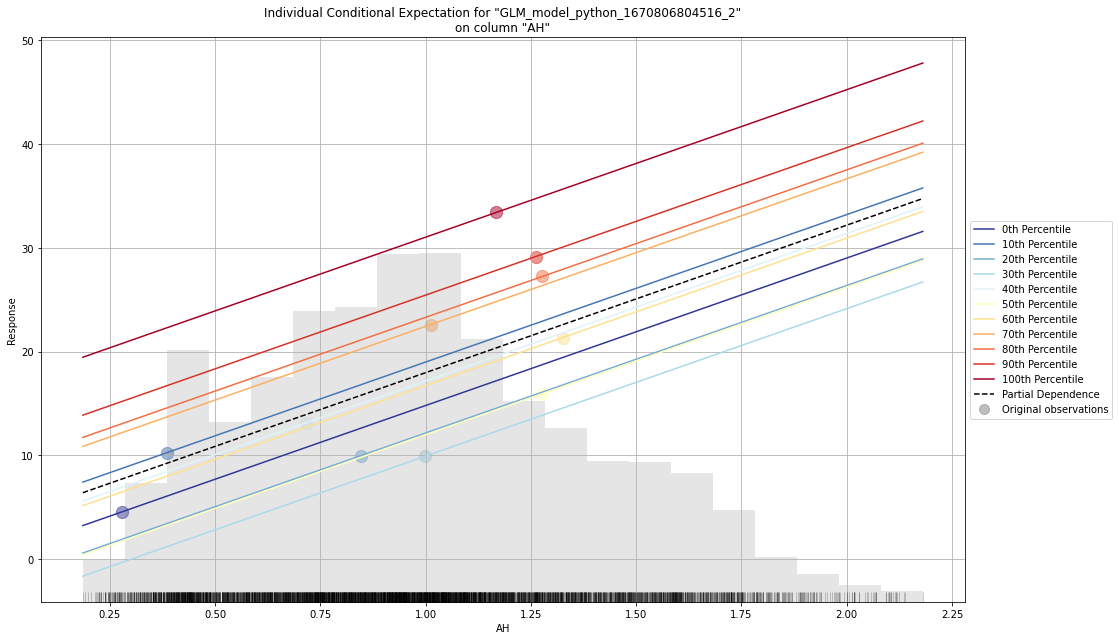

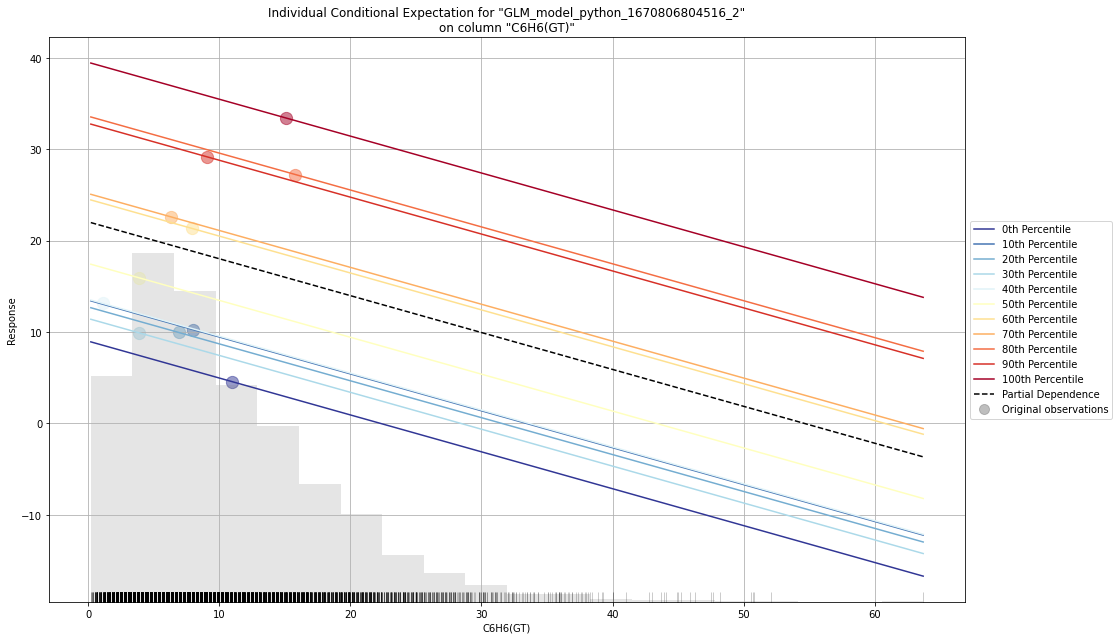

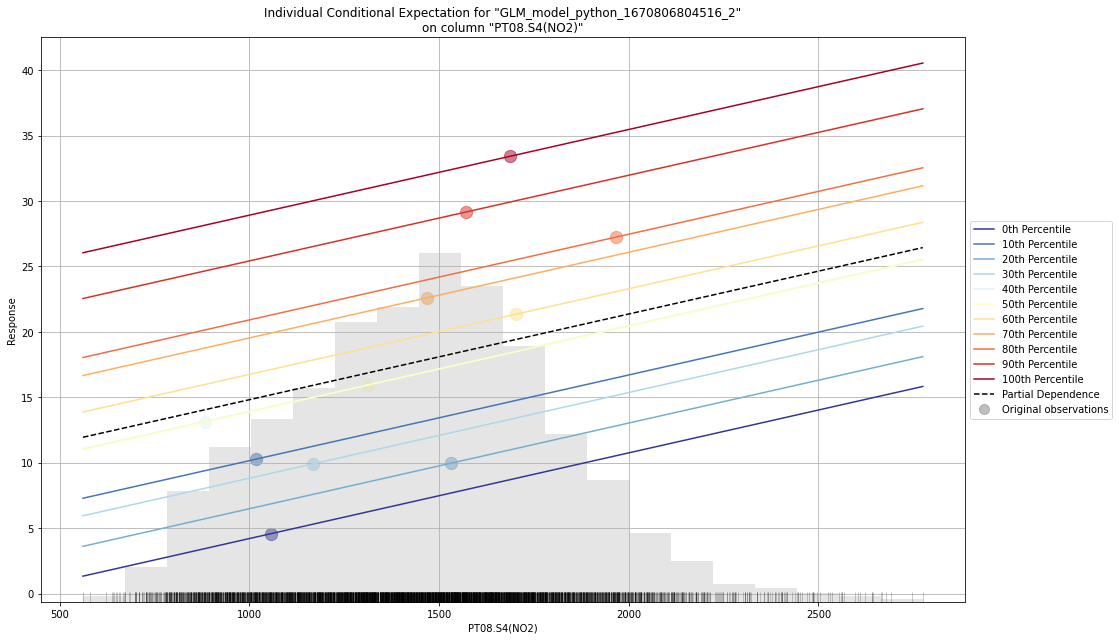

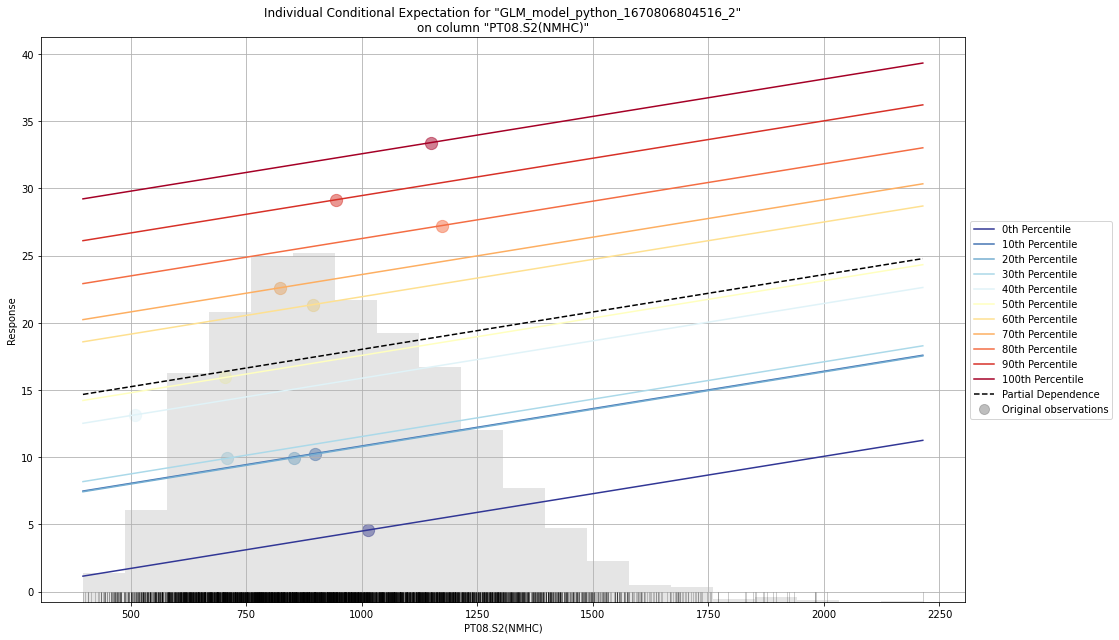

In [65]:
exm = air_glm.explain(s12_train)

Cause h2o doesn't provide a method for linear regression to get SHAP plot. So here below I need to start over again to build up a new linear model but don't use h2o:

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install shap 
import shap
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
data = pd.read_csv("https://raw.githubusercontent.com/ChenPingA/Air-Quality-Data-Set/main/AirQualityUCI.csv")
col=['DATE','TIME','CO_GT','PT08_S1_CO','NMHC_GT','C6H6_GT','PT08_S2_NMHC',
     'NOX_GT','PT08_S3_NOX','NO2_GT','PT08_S4_NO2','PT08_S5_O3','T','RH','AH']
dt = pd.read_csv("https://raw.githubusercontent.com/ChenPingA/Air-Quality-Data-Set/main/AirQualityUCI.csv",header=None,skiprows=1,names=col)
r=list(np.arange(len(col)))
#Na_values=-100
dt=pd.read_csv("https://raw.githubusercontent.com/ChenPingA/Air-Quality-Data-Set/main/AirQualityUCI.csv",header=None,skiprows=1,names=col,na_filter=True,
                   na_values=-100,usecols=r)

In [68]:
dt.tail(130)
dt.dropna(how='all',inplace=True)
print('Missing values:\n\n',dt.shape[0]-dt.count())
clean=(dt.shape[0]-dt.count()).sum()
print("\n")
if(clean==0):
    print("No Missing Values")

Missing values:

 DATE            0
TIME            0
CO_GT           0
PT08_S1_CO      0
NMHC_GT         0
C6H6_GT         0
PT08_S2_NMHC    0
NOX_GT          0
PT08_S3_NOX     0
NO2_GT          0
PT08_S4_NO2     0
PT08_S5_O3      0
T               0
RH              0
AH              0
dtype: int64


No Missing Values


In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression

In [70]:
X=dt.drop(columns=['T','DATE','TIME'])     
Y=dt['T']   
SScaler=StandardScaler()
Xsd=SScaler.fit_transform(X)    #applying stardardisation
X.head()

,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOX_GT,PT08_S3_NOX,NO2_GT,PT08_S4_NO2,PT08_S5_O3,RH,AH
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,48.9,0.7578
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,47.7,0.7255
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,54.0,0.7502
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,60.0,0.7867
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,59.6,0.7888


In [71]:
X_train, X_test, y_train, y_test=train_test_split(Xsd,Y,test_size=0.4, random_state=3)

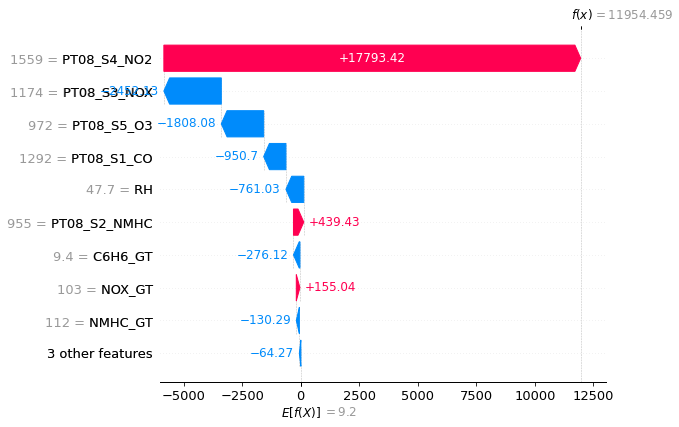

In [75]:
model= LinearRegression()
model.fit(X_train,y_train)
# model
explainer = shap.explainers.Linear(model,X_train)
shap_values=explainer(X)
shap.plots.waterfall(shap_values[1])

**2. SHAP for GBM model**

For each sample, the SHAP value for each of its features, which provides a better understanding of overall patterns and allows the discovery of prediction outliers. Each row represents a feature, and the abscissa is the SHAP value. A point represents a sample, and the color represents the eigenvalue (red high, blue low). For example, this graph shows that higher values ​​of the AH feature higher the predicted temperature

In [80]:
gbm_params3 = {'learn_rate': [0.01, 0.1],
                'max_depth': [3, 5, 9],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.2, 0.5, 1.0]}

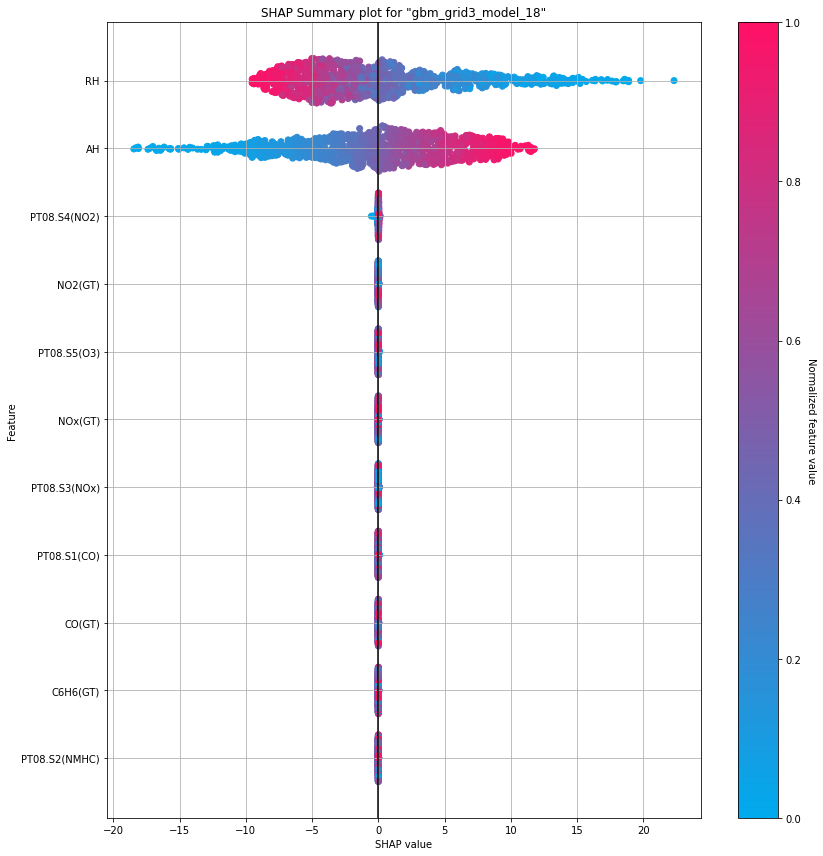

In [ ]:
shap_plot = best_gbm3.shap_summary_plot(s12_train)

AH is very important to the model, and most of AH blue points have a shap value of less than 0, which has a negative impact;
The bigger the eigenvalue, the shap is greater than 0, which has a positive impact

From a horizontal perspective, the AH feature, the sample distribution is relatively scattered, which means that the feature has a greater impact.

In addition, such as feature NO2(GT), most of the points are diffused in SHAP = 0, so it has little effect on temperature.

In [ ]:
contribution = best_gbm3.predict_contributions(s12_train)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# convert the H2O Frame to use with shap's visualization functions
contribution_matrix = contribution.as_data_frame().to_numpy()
# shap values are calculated for all features
shap_value = contribution_matrix[:,0:11]
# expected values is the last returned column
expected_values = contribution_matrix[:,11].min()
shap.initjs()
shap.force_plot(expected_values,shap_value[0])

shap_values[0].values ​​shows the shap values ​​of the 10 features of the first sample 


Therefore, the average f(x) value of all samples in the figure: 17.81, and the sum of the sample shap values ​​is f(x) -> 13.58

And both AH and RH have negative influence to the temperature 

**3. SHAP for XGBoost model**

In [ ]:
contributions = best_model.predict_contributions(s12_train)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


convert the H2O Frame to use with shap's visualization functions, and then calculate shap value for all features:

In [ ]:
# convert the H2O Frame to use with shap's visualization functions
contributions_matrix = contributions.as_data_frame().to_numpy()
# shap values are calculated for all features
shap_values = contributions_matrix[:,0:11]
# expected values is the last returned column
expected_value = contributions_matrix[:,11].min()

In [ ]:
shap.initjs()
shap.force_plot(expected_value,shap_values[0])



the average f(x) value of all samples in the figure: 17.77, the sum of the shap value is f(x) -> 14.05



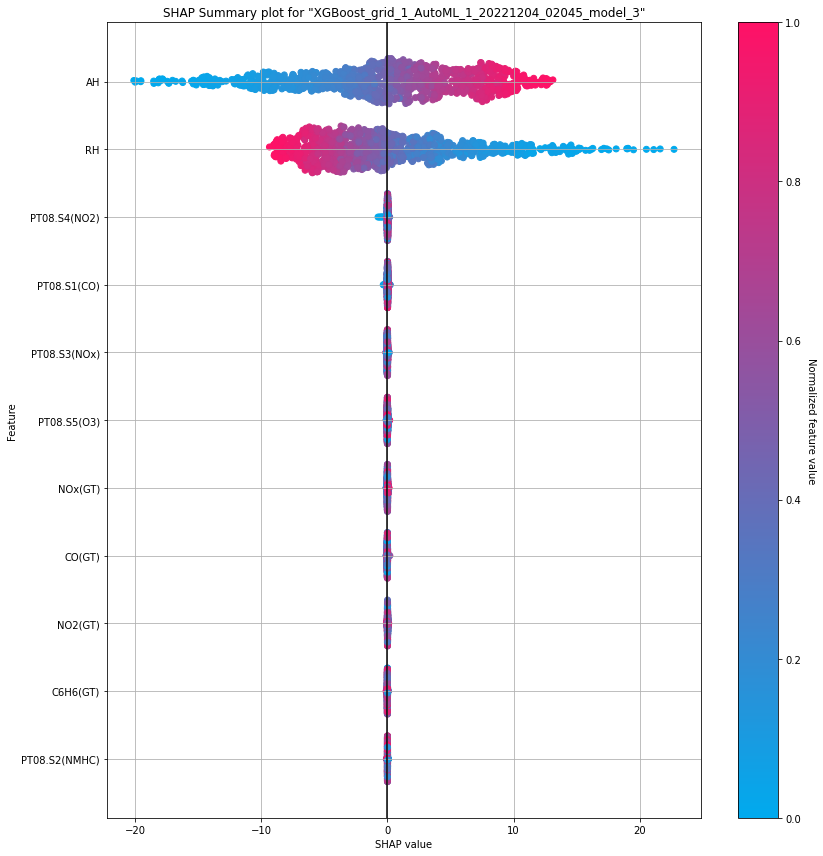

In [ ]:
shap_plot = best_model.shap_summary_plot(s12_train)

SHAP provides a method for comparing the importance of independent variables, that is, the average value of the absolute value of the SHAP value of each feature is used as the importance of the feature, and a standard bar chart is obtained

Looking at the picture, we can see that AH and RH have a greater impact on the model, among which the blue points in AH have a negative effect, and the red points have a positive effect. Secondly, the characteristics of AH are relatively scattered.

Except for AH and RH, the shap values of other factors are concentrated at 0, so they have little effect on temperature.

A SHAP interpretation shows the contribution of a particular instance's features. The sum of the feature contribution and the bias term is equal to the model's original prediction, that is, the prediction before applying the reverse link function. H2O implements TreeSHAP. This allows the contribution of features that do not affect predictions to be increased when the features are correlated.

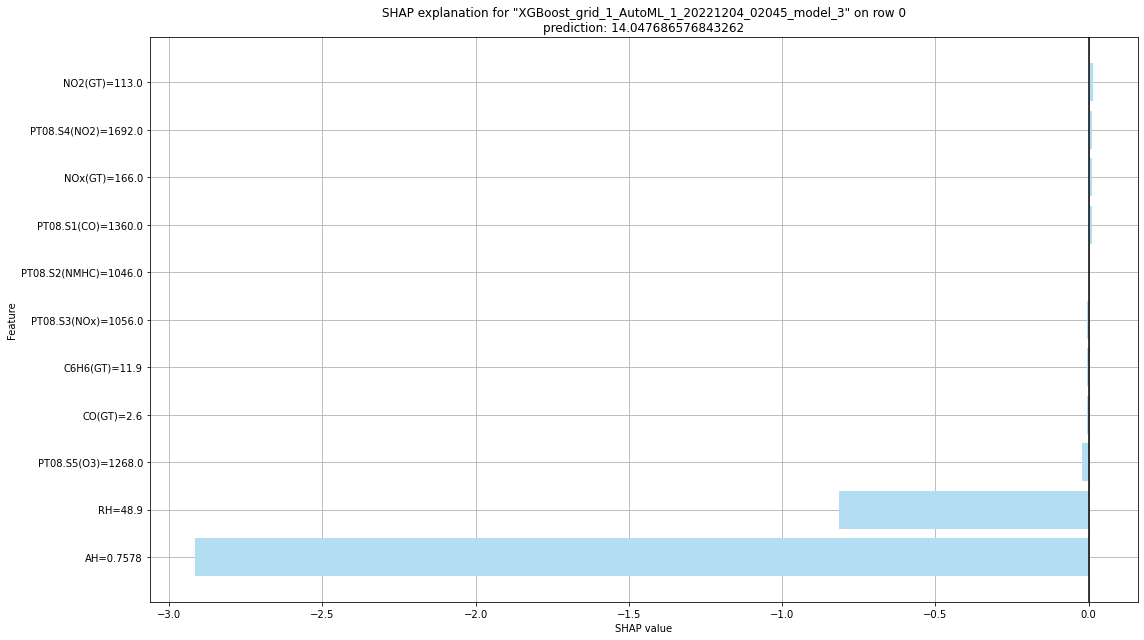

In [ ]:
shapr_plot = best_model.shap_explain_row_plot(s12_train, row_index=0)

This is another illustration, it can be clearly seen that AH and RH have a large shap value, and these two factors have an important negative impact on temperature

# Conclusion:


From the p-value in the linear regression analysis, we can know that AH and RH are the most significant variable.and the other variable’s importance.

we can tell from the z_value. In GLM model ,except NO2(GT), PT08.S3(NOx),PT08.S1(CO) are less than abs( 1.96) .Other variable is significant to the response.

We can get the mse of each model from the Hyper-Parameter Search Summary table. The smaller the mse, the smaller the model prediction error. The table shows that gbm18 is the model with the smallest mse. gbm18 is the prediction model with the smallest error

From the results of our SHAP analysis of the three models, we can conclusion:
AH is very important to the model, and most of AH blue points have a shap value of less than 0, which has a negative impact;
The bigger the eigenvalue, the shap is greater than 0, which has a positive impact
From a horizontal perspective, the AH feature, the sample distribution is relatively scattered, which means that the feature has a greater impact.
In addition, such as feature NO2(GT), most of the points are diffused in SHAP = 0, so it has little effect on temperature.

# Citation:
1.https://blog.csdn.net/qq_43800119/article/details/121187457

2.https://blog.csdn.net/Gin077/article/details/104447461

3.https://blog.dataiku.com/tree-based-models-how-they-work-in-plain-english

4.https://cloud.tencent.com/developer/article/1880798


Copyright (c) [2022] [Ping Chen]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.